# Trading Gym Example With Stable-Baselines3

In [1]:
import os
import warnings

import gymnasium as gym
import numpy as np
import pandas as pd
import requests
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.vec_env import DummyVecEnv, VecEnvWrapper
from stable_baselines3.common.evaluation import evaluate_policy

from gym_trading.envs.data_loader import PandasAssetChartDataLoader
from gym_trading.envs.exchange import BaseExchange
from gym_trading.envs.renderer import PyGamePlotRenderer
from gym_trading.envs.rewards import ProfitRewarder, OneStepProfitRewarder
from gym_trading.envs.action_space import BudgetAllocationSpace

from abc import ABC, abstractmethod

# Hide all warnings
warnings.filterwarnings("ignore")

In [2]:
def get_top_ranked_cryptos(n):
    url = f"https://api.coingecko.com/api/v3/coins/markets?vs_currency=usd&order=market_cap_desc&per_page={n}&page=1&sparkline=false"

    response = requests.get(url)
    data = response.json()

    top_cryptos = []
    for crypto in data:
        # print(crypto)
        top_cryptos.append(crypto['id'])

    return top_cryptos

In [3]:
def get_symbol_history(symbol, n_days):
    url = f'https://api.coingecko.com/api/v3/coins/{symbol}/market_chart'
    params = {
        'vs_currency': 'usd',
        'days': str(n_days),
    }
    response = requests.get(url, params=params)
    data = response.json()

    # Extract dates and prices from the API response
    timestamps = data['prices']
    dates = [pd.to_datetime(timestamp, unit='ms') for timestamp, _ in timestamps]
    prices = [price for _, price in timestamps]
    market_caps = [market_cap for _, market_cap in data['market_caps']]
    total_volumes = [total_volume for _, total_volume in data['total_volumes']]
    
    print(f'{symbol.upper()}: {len(dates) = }, {len(prices) = }, {len(market_caps) = }, {len(total_volumes) = }')

    return pd.DataFrame({
        'Date': dates,
        'Price': prices,
        'Market Cap': market_caps,
        'Total Volume': total_volumes
    })

In [4]:
N_DAYS = 365 * 2
SAVE_DIR = "crypto_datasets__days-" + str(N_DAYS)

In [5]:
def save_datasets(datasets, days):
    if not os.path.exists(SAVE_DIR):
        os.makedirs(SAVE_DIR)

    for symbol, df in datasets.items():
        filename = f"{symbol}_{days}_days.csv"
        file_path = os.path.join(SAVE_DIR, filename)
        df.to_csv(file_path, index=False)
        print(f"Saved {symbol} dataset to {file_path}")
        
def load_datasets():
    datasets = {}
    try:
        for file in os.listdir(SAVE_DIR):
            if file.endswith(".csv"):
                symbol, days, _ = file.split("_")
                days = int(days)
                file_path = os.path.join(SAVE_DIR, file)
                df = pd.read_csv(file_path)
                datasets[symbol] = df
    except FileNotFoundError:
        return datasets
    return datasets

In [6]:
datasets = load_datasets()

if len(datasets.keys()) == 0:
    print('downloading new data')
    
    top_cryptos = get_top_ranked_cryptos(10)
    print('Downloading datasets for top cryptos: {top_cryptos}')
    
    df = pd.DataFrame()

    for symbol in top_cryptos:
        df = get_symbol_history(symbol, N_DAYS)

        # removing the last row since sometimes are not aligned
        df.drop(df.index[-1], inplace=True)

        datasets[symbol] = df
        
    save_datasets(datasets, N_DAYS)

In [7]:
for symbol, df in datasets.items():
    df['Date'] = pd.to_datetime(df['Date'])

In [8]:
# Removing stable coins and crypto with less days than expected
del datasets['staked-ether']
del datasets['tether']
del datasets['usd-coin']
del datasets['solana']

In [9]:
df = list(datasets.values())[0]
df['Date'].iloc[1] - df['Date'].iloc[0]

Timedelta('1 days 00:00:00')

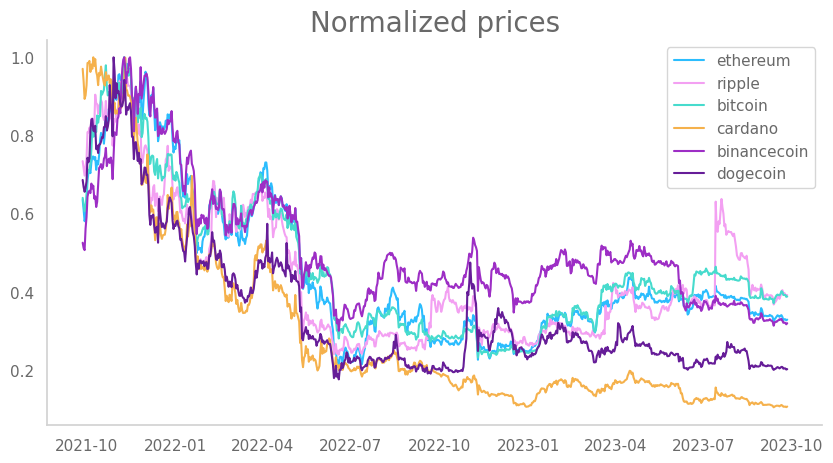

In [10]:
for symbol, df in datasets.items():
    plt.plot(df['Date'], df['Price'] / np.max(df['Price']), label=symbol)

plt.title('Normalized prices')
plt.legend()
plt.show()

In [11]:
SYMBOLS = list(datasets.keys())
SYMBOLS

['ethereum', 'ripple', 'bitcoin', 'cardano', 'binancecoin', 'dogecoin']

In [12]:
def train_valid_test_df(df, split_rate=0.2):
    train_df, test_df = train_test_split(df, test_size=split_rate, shuffle=False)
    train_df, valid_df = train_test_split(train_df, test_size=split_rate, shuffle=False)
    return train_df, valid_df, test_df

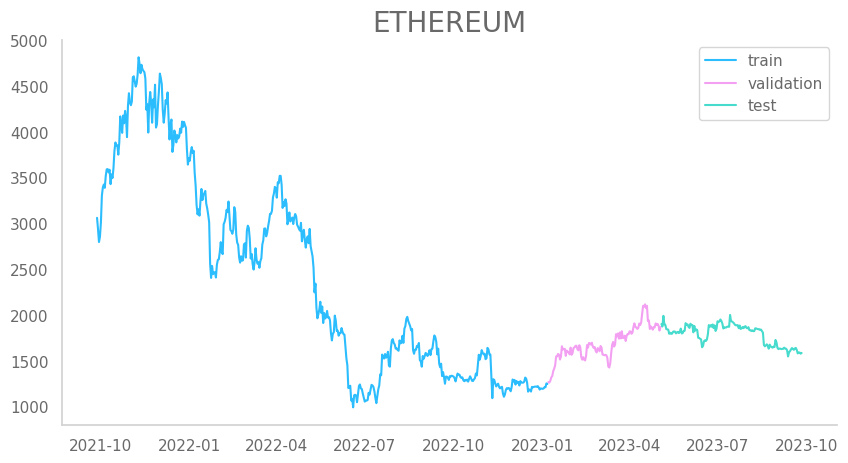

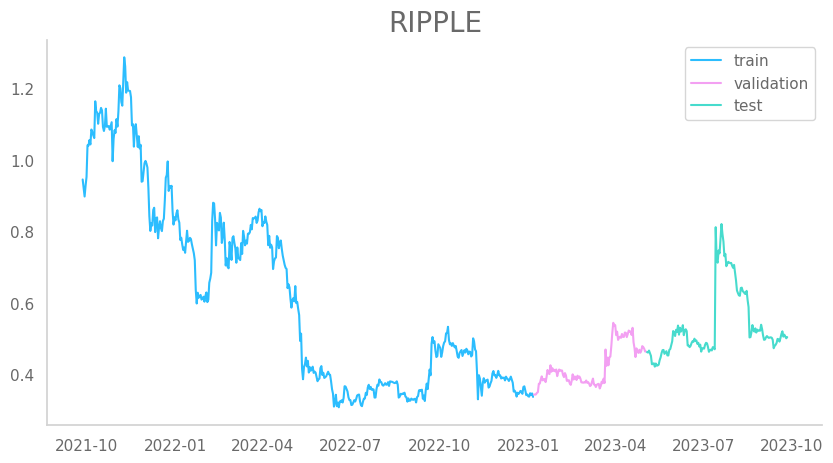

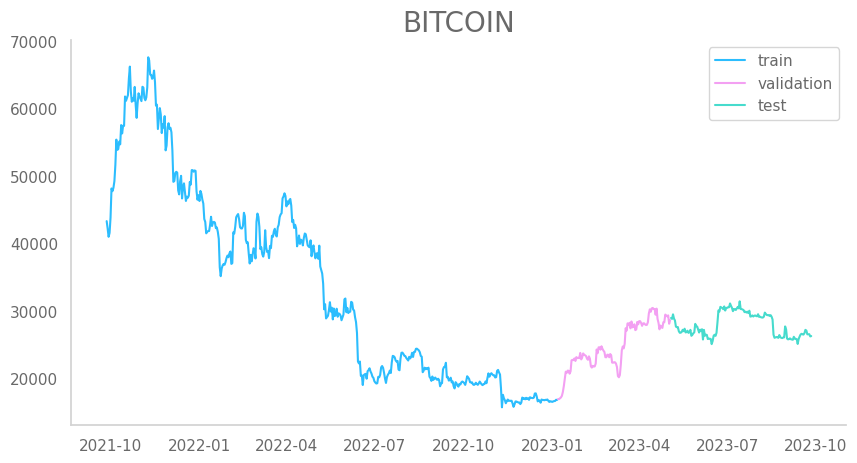

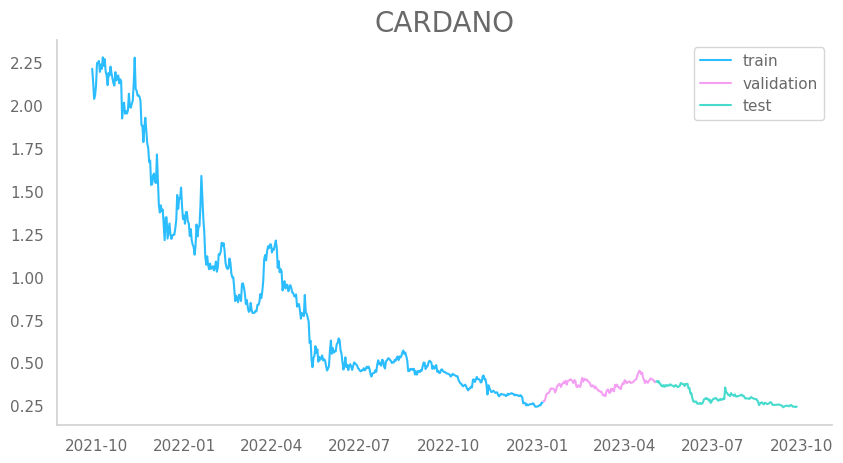

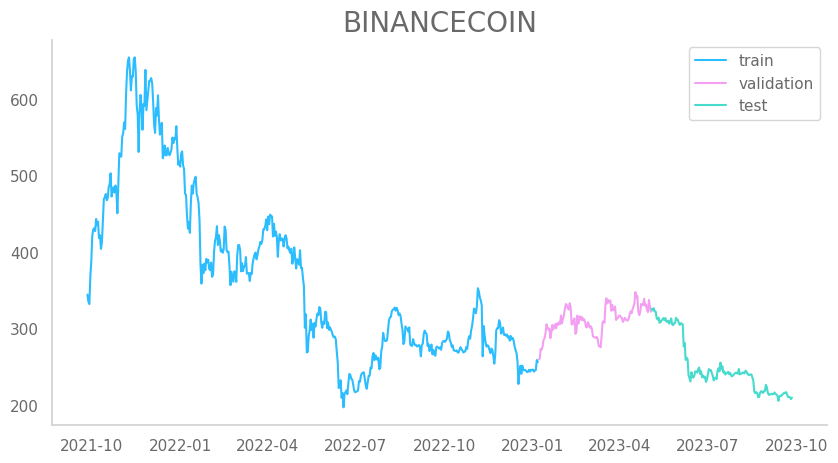

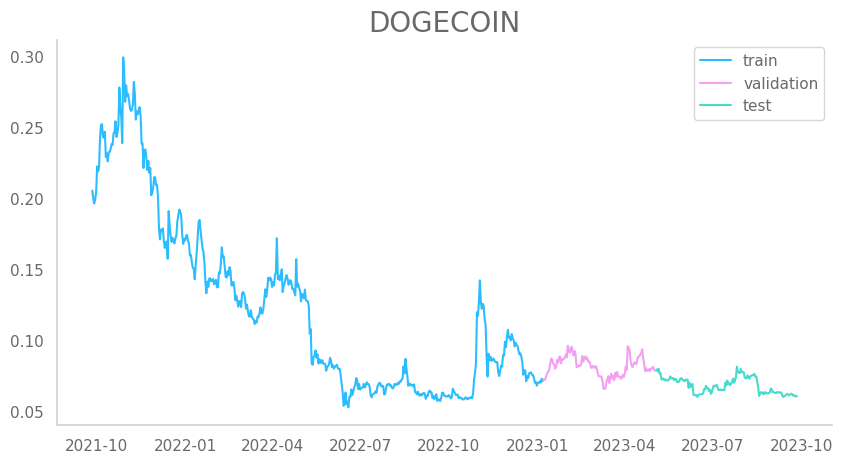

In [13]:
split_datasets = {}
for symbol, df in datasets.items():
    split_datasets[symbol] = train_valid_test_df(df)

    plt.plot(split_datasets[symbol][0]['Date'], split_datasets[symbol][0]['Price'], label=f'train')
    plt.plot(split_datasets[symbol][1]['Date'], split_datasets[symbol][1]['Price'], label=f'validation')
    plt.plot(split_datasets[symbol][2]['Date'], split_datasets[symbol][2]['Price'], label=f'test')

    plt.title(symbol.upper())
    plt.legend()
    plt.show()

In [14]:
INIT_LIQUIDITY = 100.0
BUY_FEE = 0.1
SELL_FEE = 0.1

# TRAIN ENV
train_data_loader = PandasAssetChartDataLoader(
    datasets={symbol: split[0] for symbol, split in split_datasets.items()},
    timestamp_column_name='Date',
    price_column_name='Price'
)
train_env = gym.make(
    'gym_trading:trading-v0',
    data_loader=train_data_loader,
    exchange=BaseExchange(train_data_loader, init_liquidity=INIT_LIQUIDITY, buy_fee=BUY_FEE, sell_fee=SELL_FEE),
    rewarder=OneStepProfitRewarder(),
)

# VALID ENV
valid_data_loader = PandasAssetChartDataLoader(
    datasets={symbol: split[1] for symbol, split in split_datasets.items()},
    timestamp_column_name='Date',
    price_column_name='Price'
)
valid_env = gym.make(
    'gym_trading:trading-v0',
    data_loader=valid_data_loader,
    exchange=BaseExchange(valid_data_loader, init_liquidity=INIT_LIQUIDITY, buy_fee=BUY_FEE, sell_fee=SELL_FEE),
    rewarder=OneStepProfitRewarder(),
)

# TEST ENV
test_data_loader = PandasAssetChartDataLoader(
    datasets={symbol: split[2] for symbol, split in split_datasets.items()},
    timestamp_column_name='Date',
    price_column_name='Price'
)
test_env = gym.make(
    'gym_trading:trading-v0',
    data_loader=test_data_loader,
    exchange=BaseExchange(test_data_loader, init_liquidity=INIT_LIQUIDITY, buy_fee=BUY_FEE, sell_fee=SELL_FEE),
    rewarder=OneStepProfitRewarder(),
    renderer=PyGamePlotRenderer(render_fps=4),
    final_report_plot=True
)

In [15]:
observation = train_env.reset()[0]
observation

array([[3.0633164e+03, 3.5968064e+11, 2.4916718e+10, 9.4576734e-01,
        4.4610630e+10, 3.7446597e+09, 4.3336859e+04, 8.2534112e+11,
        3.0462816e+10, 2.2128837e+00, 7.2357773e+10, 3.3075400e+09,
        3.4456046e+02, 5.4001566e+10, 1.8414981e+09, 2.0572148e-01,
        2.7453143e+10, 1.0692258e+09]], dtype=float32)

In [16]:
observation.shape

(1, 18)

In [17]:
from stable_baselines3.common.vec_env import SubprocVecEnv, VecNormalize, StackedObservations

train_vec_env = VecNormalize(SubprocVecEnv([lambda: train_env] * 8))
valid_vec_env = VecNormalize(DummyVecEnv([lambda: valid_env]))
test_vec_env = VecNormalize(DummyVecEnv([lambda: test_env]))

In [18]:
from sb3_contrib import RecurrentPPO

log_dir = './logs/'
time_steps = 1e6

model = RecurrentPPO(
    policy="MlpLstmPolicy",
    env=train_vec_env,
    verbose=0,
    tensorboard_log=log_dir,
)

eval_callback = EvalCallback(
    eval_env=valid_vec_env,
    best_model_save_path='./models',
    log_path=log_dir,
    eval_freq=5000,
    n_eval_episodes=1,
    deterministic=True,
    render=False
)

callbacks = [eval_callback]

model.learn(
    total_timesteps=int(time_steps),
    callback=callbacks,
    progress_bar=True
)

Output()

Eval num_timesteps=40000, episode_reward=1.77 +/- 0.00

Episode length: 117.00 +/- 0.00

New best mean reward!

Eval num_timesteps=80000, episode_reward=1.50 +/- 0.00

Episode length: 117.00 +/- 0.00

Eval num_timesteps=120000, episode_reward=2.86 +/- 0.00

Episode length: 117.00 +/- 0.00

New best mean reward!

Eval num_timesteps=160000, episode_reward=1.23 +/- 0.00

Episode length: 117.00 +/- 0.00

Eval num_timesteps=200000, episode_reward=1.51 +/- 0.00

Episode length: 117.00 +/- 0.00

Process ForkServerProcess-3:
Process ForkServerProcess-4:
Process ForkServerProcess-7:
Process ForkServerProcess-1:
Traceback (most recent call last):
  File "/home/damiano/miniconda3/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/damiano/miniconda3/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/damiano/PycharmProjects/gym-trading/venv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/subproc_vec_env.py", line 33, in _worker
    cmd, data = remote.recv()
  File "/home/damiano/miniconda3/lib/python3.10/multiprocessing/connection.py", line 251, in recv
    return _ForkingPickler.loads(buf.getbuffer())
KeyboardInterrupt
Process ForkServerProcess-2:
Process ForkServerProcess-8:
Process ForkServerProcess-6:
Traceback (most recent call last):
  File "/home/damiano/miniconda3/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
 

KeyboardInterrupt: 

In [19]:
%load_ext tensorboard
%tensorboard --logdir ./logs/

In [ ]:
best_model = RecurrentPPO.load('./models/best_model.zip')

mean_reward, std_reward = evaluate_policy(
    model,
    test_vec_env,
    n_eval_episodes=1,
    deterministic=True,
)

test_vec_env.close()

print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")